<font size="+3"><strong> Predicting Apartment Prices in Mexico City 🇲🇽</strong></font>

In [1]:
# Import libraries here
import warnings
from glob import glob

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

# Prepare Data

## Import

 Write a wrangle function that takes the name of a CSV file as input and returns a DataFrame. 

In [2]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Distrito Federall", less than 100,000
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    df.drop(columns="Unnamed: 0", inplace=True)
    
    # Extract neighborhood
    df["borough"]=df["place_with_parent_names"].str.split("|",  expand=True)[1]
    df.drop(columns=["place_with_parent_names"], inplace=True)

    # Drop columns with high null values
    df.drop(columns=["price_usd_per_m2",
                     "floor",
                     "surface_total_in_m2",
                     "rooms",
                     "expenses",
                     "operation",
                     "property_type",
                     "currency"
                    ], 
                        inplace=True)

    # Drop low- cardinality categorical variables
    df.drop(columns=["properati_url"], inplace=True)

    # Drop leaky columns
    df.drop(columns=[
        'price',
         'price_aprox_local_currency',
         'price_per_m2',
        
    ], 
            inplace=True)
    
    return df

In [3]:
# Use this cell to test my wrangle function and explore the data
df = wrangle("data/mexico-city-real-estate-1.csv")
print("df shape:", df.shape)

df.head()

df shape: (1101, 5)


price_aprox_usd  surface_covered_in_m2        lat         lon  \
11         94022.66                   57.0  23.634501 -102.552788   
20         70880.12                   56.0  19.402413  -99.095391   
21         68228.99                   80.0  19.357820  -99.149406   
22         24235.78                   60.0  19.504985  -99.208557   
26         94140.20                   50.0  19.354219  -99.126244   

          borough  
11  Benito Juárez  
20      Iztacalco  
21  Benito Juárez  
22   Azcapotzalco  
26       Coyoacán

Use glob to create the list files. It should contain the filenames of all the Mexico City real estate CSVs

In [4]:
import glob

files= glob.glob("./data/mexico-city-real-estate-[0-9].csv")
files

['./data\\mexico-city-real-estate-1.csv',
 './data\\mexico-city-real-estate-2.csv',
 './data\\mexico-city-real-estate-3.csv',
 './data\\mexico-city-real-estate-4.csv',
 './data\\mexico-city-real-estate-5.csv']

 Combine your wrangle function, a list comprehension, and pd.concat to create a DataFrame df

In [5]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB
None


price_aprox_usd  surface_covered_in_m2        lat         lon  \
0         94022.66                   57.0  23.634501 -102.552788   
1         70880.12                   56.0  19.402413  -99.095391   
2         68228.99                   80.0  19.357820  -99.149406   
3         24235.78                   60.0  19.504985  -99.208557   
4         94140.20                   50.0  19.354219  -99.126244   

         borough  
0  Benito Juárez  
1      Iztacalco  
2  Benito Juárez  
3   Azcapotzalco  
4       Coyoacán

In [6]:
#df.to_csv("data/mexico-real-estate-clean.csv",index=False)

## Explore

Plot a correlation heatmap of the remaining numerical features in df

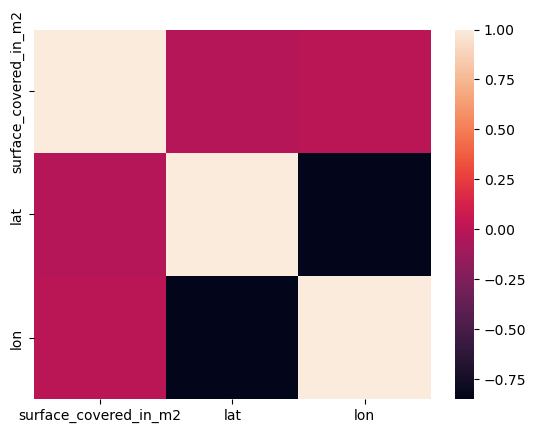

In [7]:
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
sns.heatmap(corr);

 Create a histogram showing the distribution of apartment prices ("price_aprox_usd")

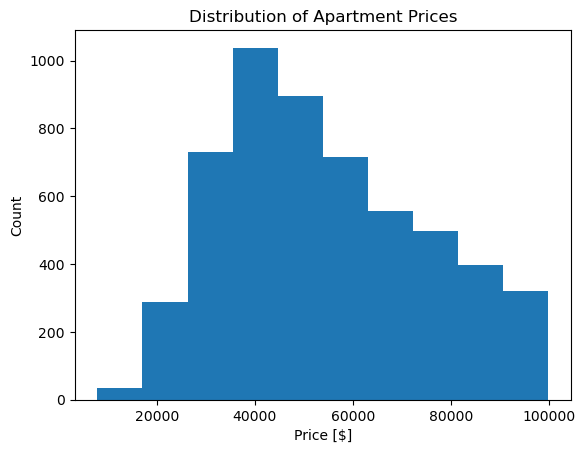

In [8]:
# Build histogram
plt.hist(df["price_aprox_usd"])


# Label axes
plt.xlabel("Price [$]")
plt.ylabel("Count")

# Add title
plt.title("Distribution of Apartment Prices");


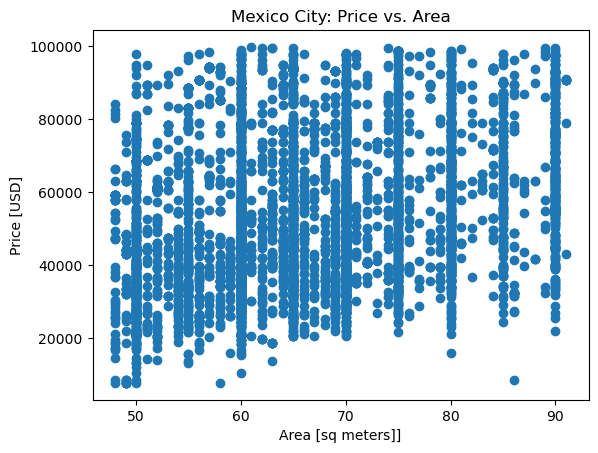

In [9]:
# Build scatter plot
plt.scatter(x=df["surface_covered_in_m2"], y=df["price_aprox_usd"])
plt.xlabel("Area [sq meters]]")
plt.ylabel("Price [USD]")
plt.title("Mexico City: Price vs. Area");

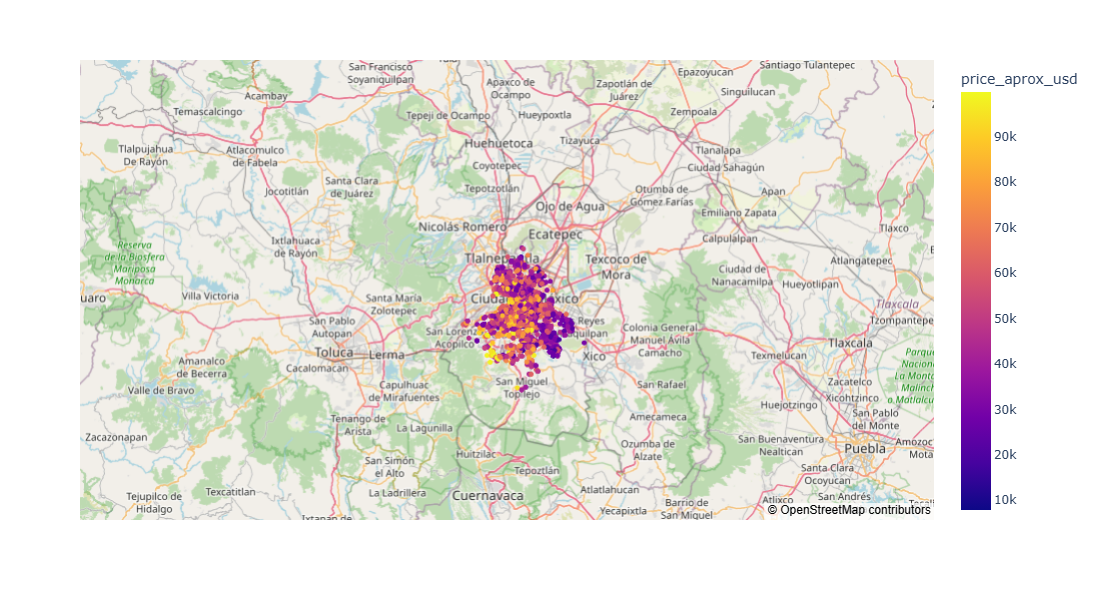

In [10]:
# Plot Mapbox location and price
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat="lat",
    lon="lon",
    width=600,  # Width of map
    height=600,  # Height of map
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

## Split Data

In [11]:
target = "price_aprox_usd"
X_train = df.drop(columns=target)
y_train= df[target]

# Build Model

## Baseline

In [12]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)

baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(baseline_mae, 2))

Mean apt price 54246.53
Baseline MAE: 17239.94


## Iterate

In [13]:
# Create a pipeline named model that contains a OneHotEncoder, SimpleImputer, and Ridge predictor.

model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Evaluate

Calculate the training mean absolute error for the predictions as compared to the true targets in y_train

In [14]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 14943.165824063908


Read the CSV file mexico-city-test-clean.csv into the DataFrame X_test

In [15]:
X_test = pd.read_csv("data/mexico-real-estate-clean.csv")

Use model to generate a Series of predictions for X_test

In [16]:
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    74307.134826
1    49999.341090
2    70485.089140
3    53551.000722
4    51635.387219
dtype: float64

# Communicate Results

Create an interact function in Jupyter Widgets.

In [17]:
def make_prediction(area, lat, lon, borough):
    data = {
        "surface_coverd_in_m2":area,
        "lat":lat,
        "lon":lon,
        "borough":borough
    }
    df = pd.DataFrame(data, index=[0]).round(2)[0]
    prediction = model.predict(df)
    return f"Predicted apartment price: ${prediction}"

In [18]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    borough=Dropdown(options=sorted(X_train["borough"].unique())),
);

interactive(children=(IntSlider(value=66, description='area', max=91, min=48), FloatSlider(value=19.4531123034…

 Create a Series named feat_imp

In [19]:
# retrieve intercept
intercept = model.named_steps["ridge"].intercept_

# retrieve coefficients
coefficients = model.named_steps["ridge"].coef_

# rerieve banes
feature_names= model.named_steps["onehotencoder"].get_feature_names_out()

# create a series of names and values
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

surface_covered_in_m2      291.654156
lat                        478.901375
lon                      -2492.221814
borough_Benito Juárez    13778.188880
borough_Iztacalco          405.403127
dtype: float64

 Create a horizontal bar chart that shows the 10 most influential coefficients for your model

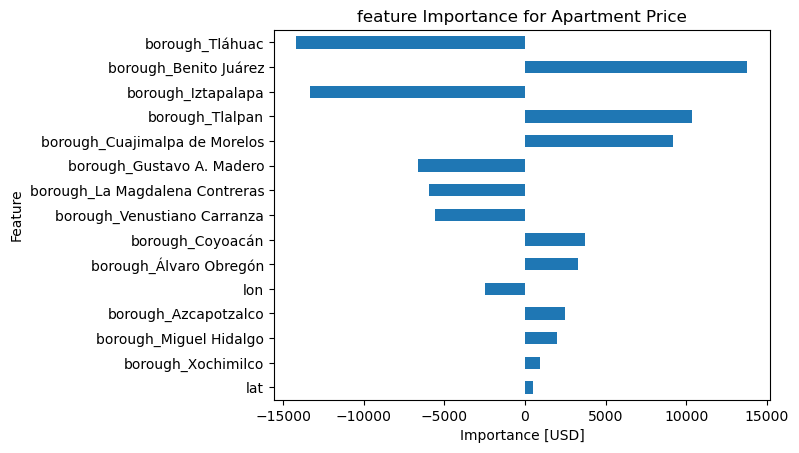

In [20]:
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("feature Importance for Apartment Price");

Looking at this bar chart, we can see that the poshest borough in Mexico City like Benito Juárez and Tlalpan increase the predicted price of an apartment, while more working-class borough like Tlahuac and Iztacalco decrease the predicted price.